In [4]:
# Packages
!pip install --upgrade pip
!pip install --upgrade ipython jupyter
!pip install keras
!pip install tensorflow
!pip install tqdm
!pip install seaborn
!pip install imutils
!pip install opencv-python
!pip install staintools
!pip install spams

"""
 To obtain the dataset for this project visit this Google Drive
    https://drive.google.com/drive/folders/1JwLRvkkvZowtWnMi7TfiFdHjyNj9lbXX?usp=sharing
"""

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [8]:
# Import libraries
import os 
import cv2
import gc
import json
import glob
import keras
import math
import scipy
import shutil
from os import listdir
import numpy as np 
import pandas as pd 
from PIL import Image
from tqdm import tqdm
import xgboost as xgb
import tensorflow as tf 
from tensorflow import keras
import matplotlib.pyplot as plt
from keras import backend as K
from keras.utils import np_utils
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.externals import joblib
from sklearn import metrics
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import models, layers
from tensorflow.keras import Model 
from tensorflow.keras.models import Model, model_from_json, Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Input, GlobalAveragePooling2D, DepthwiseConv2D, concatenate
from keras.applications import ResNet50,MobileNet, DenseNet201, InceptionV3, InceptionResNetV2, VGG16, Xception
from keras.preprocessing.image import img_to_array
from keras.preprocessing import image
from keras.optimizers import Adam, Adadelta, RMSprop
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from IPython.core.interactiveshell import InteractiveShell

--- This graphs shows the class imbalance of the dataset ---


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


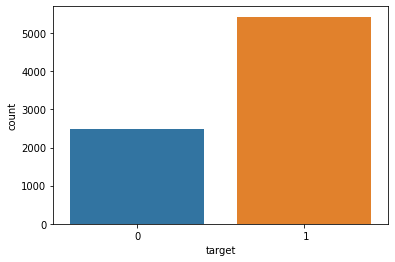

--- Value count after resampling ---


1    5429
0    5429
Name: target, dtype: int64

In [9]:
# Extract the files from path
def getListOfFiles(dirName):
    listOfFile = os.listdir(dirName)
    allFiles = list()
    for entry in listOfFile:
        fullPath = os.path.join(dirName, entry)
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
    #print(allFiles)    
    return allFiles

benign=getListOfFiles('../content/drive/MyDrive/BreaKHis/norma/Benign')
malignant=getListOfFiles('../content/drive/MyDrive/BreaKHis/norma/Malignant')

data = pd.DataFrame(index=np.arange(0, len(benign)+len(malignant)), columns=["image", "target"])
k=0

# Label image classes from 0-1
for c in [0,1]:
        if c==1:
            for m in range(len(benign)):
                data.iloc[k]["image"] = benign[m]
                data.iloc[k]["target"] = 0
                k += 1
        else:
            for m in range(len(malignant)):
                data.iloc[k]["image"] = malignant[m]
                data.iloc[k]["target"] = 1
                k += 1

# print(data)
# count=data["target"].value_counts() 
# count

# Visualize the target variable
print("--- This graphs shows the class imbalance of the dataset ---")
target=sns.countplot(data['target'])
target.set_xticklabels(['0',' 1'])
plt.show()

# Downsample the malignant targets
mal_upsampled = resample(data[data['target']==0],n_samples=data[data['target']==1].shape[0], random_state=42)
# Combine minority and downsampled majority
upsampled = pd.concat([data[data['target']==1], mal_upsampled])
# Check new class counts
print("--- Value count after resampling ---")
upsampled['target'].value_counts()              

In [10]:
# Prepare images
train_image = []
y = []

for i in tqdm(range(upsampled.shape[0])):
    img = image.load_img(upsampled['image'].iloc[i], target_size=(224,224,1), grayscale=False)
    img = image.img_to_array(img)
    img = img/255
    train_image.append(img)

X = np.array(train_image)
y = upsampled.iloc[:,-1].values

# Splitting dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, random_state=42, test_size=0.2 , shuffle=True)

Y_train = np_utils.to_categorical(y_train, 2)
Y_test = np_utils.to_categorical(y_test, 2)
Y_val = np_utils.to_categorical(y_val, 2)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

100%|██████████| 10858/10858 [1:14:08<00:00,  2.44it/s]


(8686, 224, 224, 3)
(1737, 224, 224, 3)
(435, 224, 224, 3)


In [11]:
from keras.applications import DenseNet201

BATCH_SIZE = 10

def build_model(backbone, lr=1e-4):
    model = Sequential()
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(2, activation='softmax'))
    
    model.compile(
        loss='categorical_crossentropy',
        optimizer=RMSprop(lr=lr),
        metrics=['accuracy']
    )
    
    return model

# Data augmentation
train_generator = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range = 15,
    horizontal_flip = True,
    vertical_flip = True,
    fill_mode='nearest',
    zoom_range = 0.20)

K.clear_session()
gc.collect()

DenseNet201 = DenseNet201(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)
DenseNet201 = build_model(DenseNet201 ,lr = 1e-4)

#model.summary()

74842112/74836368 [==============================] - 1s 0us/step


In [5]:
# Learning Rate Reducer
learn_control = ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1,factor=0.2, min_lr=1e-7)

# Checkpoint
filepath3 ="../content/drive/MyDrive/BinaryDenseNet201bstweights.best.hdf5"
checkpoint3 = ModelCheckpoint(filepath3, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Start training the model
history3 = DenseNet201.fit(
    train_generator.flow(X_train, Y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=X_train.shape[0] / BATCH_SIZE,
    epochs=8,
    validation_data=(X_val, Y_val),
    callbacks=[learn_control, checkpoint3]
)

Epoch 1/8
868/868 [==============================] - 5641s 6s/step - loss: 0.5392 - accuracy: 0.7565 - val_loss: 0.7941 - val_accuracy: 0.8230

Epoch 00001: val_accuracy improved from -inf to 0.82299, saving model to ../content/drive/MyDrive/BinaryDenseNet201bstweights.best.hdf5
Epoch 2/8
868/868 [==============================] - 5545s 6s/step - loss: 0.3611 - accuracy: 0.8540 - val_loss: 0.3840 - val_accuracy: 0.8874

Epoch 00002: val_accuracy improved from 0.82299 to 0.88736, saving model to ../content/drive/MyDrive/BinaryDenseNet201bstweights.best.hdf5
Epoch 3/8
868/868 [==============================] - 5706s 7s/step - loss: 0.2984 - accuracy: 0.8817 - val_loss: 0.4492 - val_accuracy: 0.9241

Epoch 00003: val_accuracy improved from 0.88736 to 0.92414, saving model to ../content/drive/MyDrive/BinaryDenseNet201bstweights.best.hdf5
Epoch 4/8
868/868 [==============================] - 5479s 6s/step - loss: 0.2728 - accuracy: 0.8905 - val_loss: 0.1373 - val_accuracy: 0.9494

Epoch 0000

In [13]:
# Loading the trained Deep Learning model
weights_path = '/content/drive/MyDrive/BinaryDenseNet201bstweights.best.hdf5'
DenseNet201.load_weights(weights_path, by_name=True)

# Set weights for initial layers
for i, layer in enumerate(DenseNet201.layers):
    weights = layer.get_weights()
    DenseNet201.layers[i].set_weights(weights)

model_final = Model(inputs = DenseNet201.input, outputs = DenseNet201.output)
Y_pred = model_final.predict(X_test)

In [14]:
print("--- Deep Learning performance ---")
classes = ['Benign','Malignant']
print(classification_report(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1), target_names=classes))

--- Deep Learning performance ---
              precision    recall  f1-score   support

      Benign       0.96      0.94      0.95       860
   Malignant       0.94      0.96      0.95       877

    accuracy                           0.95      1737
   macro avg       0.95      0.95      0.95      1737
weighted avg       0.95      0.95      0.95      1737



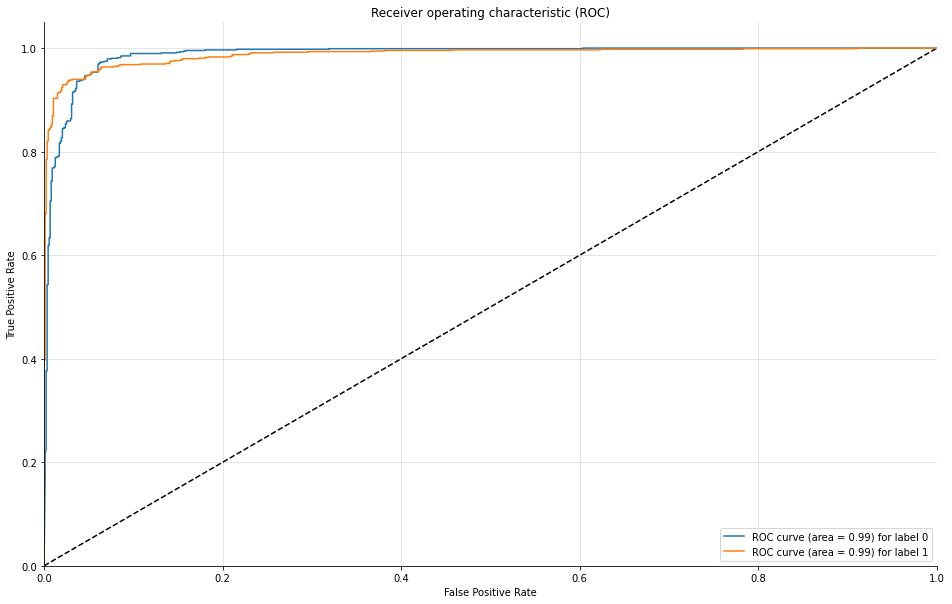

In [15]:
from sklearn.metrics import roc_curve, auc

# Visualise the ROC curve model performance for deep learning
def plot_multiclass_roc_dcnn(clf, X_test, y_test, n_classes, figsize=(17, 6)):
    y_score = clf.predict(X_test)
    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(np.argmax(y_test, axis=1), drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic (ROC)')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

# Plot the ROC curve for deep learning model
plot_multiclass_roc_dcnn(model_final, X_test, Y_test, n_classes=2, figsize=(16, 10))

In [16]:
# Using the deep learning model as feature extraction 
# Combining with an XGBoost Classifier

features = [] # Create empty list to extract features using pretrained model weights
seed = 1234 # Define seed to get consistent results

# Convert lables to categorical 
y = upsampled.iloc[:,-1].values
y = np.array(y)
y_labels_cat, _ = pd.factorize(y, sort=True)

for i in tqdm(X):
    image = np.expand_dims(i, axis=0)
    featurePredict = model_final.predict(image)
    features.append(featurePredict)

100%|██████████| 10858/10858 [39:55<00:00,  4.53it/s]


In [44]:
# Convert the feature vectors to numpy array from list    
featuresArray = np.array(features)

# Reshape to get in the right shape 
featuresReshape = featuresArray.reshape(featuresArray.shape[0], -1)
print(featuresReshape.shape)

# Split dataset 
X_train_dev, X_val, y_train_dev, y_val = train_test_split(featuresReshape, y_labels_cat, test_size=0.20, random_state=seed)
X_train, X_dev, y_train, y_dev = train_test_split(X_train_dev,y_train_dev, test_size=0.20, random_state=seed)

# Reshape the data for XGBoost 
X_train_XG = np.reshape(X_train, (X_train.shape[0], X_train.shape[1]))
X_dev_XG = np.reshape(X_dev, (X_dev.shape[0], X_dev.shape[1]))
X_val_XG = np.reshape(X_val, (X_val.shape[0], X_val.shape[1]))

# Create the XGBoost Classifier
xgb1 = xgb.sklearn.XGBClassifier(learning_rate =0.6, 
                                 n_estimators=1000, 
                                 max_depth=5, 
                                 min_child_weight=11, 
                                 gamma=0.1, 
                                 subsample=0.8, 
                                 colsample_bytree=0.7, 
                                 objective='binary:logistic', 
                                 n_jobs=-1, 
                                 scale_pos_weight=1, 
                                 seed=seed)

# Train the XGBoost classifier
xgb1.fit(X_train_XG, y_train)
xgb1.score(X_dev_XG, y_dev)
y_pred_xgb = xgb1.predict_proba(X_val_XG)

# Save the XGBoost model
joblib.dump(xgb1, 'xgbClassifierBinary.pkl')

# Print accuracy
print("Accuracy: ", xgb1.score(X_dev_XG, y_dev))

(10858, 2)
Accuracy:  0.9706559263521288


--- Confusion Matrix ---
[[1059   25]
 [  58 1030]]


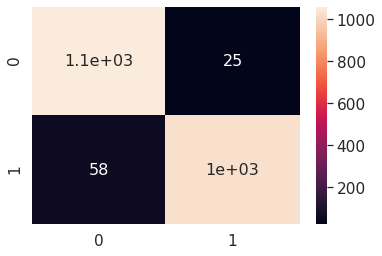

--- Classification Report ---
              precision    recall  f1-score   support

      Benign       0.95      0.98      0.96      1084
   Malignant       0.98      0.95      0.96      1088

    accuracy                           0.96      2172
   macro avg       0.96      0.96      0.96      2172
weighted avg       0.96      0.96      0.96      2172



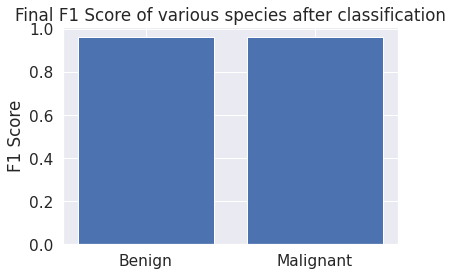

In [45]:
import seaborn as sns

# Overall model performance
def model_performance(y_val, y_pred_prob, model_name, classes):
    # Confusion matrix and classification report
    cm = confusion_matrix(y_val, y_pred_prob.argmax(axis=1))
    print("--- Confusion Matrix ---")
    print(cm)
    
    # Plot the confusion matrix figure
    df_cm = pd.DataFrame(cm, range(2), range(2))
    sns.set(font_scale=1.4) 
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}) 
    plt.show()
    
    print("--- Classification Report ---")
    print(classification_report(y_val, y_pred_prob.argmax(axis =1), target_names=classes))
    
    # Plot F1-score vs. Classes
    
    f1Score = f1_score(y_val, y_pred_prob.argmax(axis=1), average=None)
    y_pos = np.arange(len(classes))
    plt.bar(y_pos, f1Score)
    plt.xticks(y_pos, classes)
    plt.ylabel('F1 Score')
    plt.title('Final F1 Score of various species after classification')
    plt.show()
    return cm, f1Score

# Load the final model
classes = ['Benign','Malignant']
clfXGB = joblib.load('xgbClassifierBinary.pkl')
y_pred_xgb = clfXGB.predict_proba(X_val_XG)
cmXGB, f1XGB = model_performance(y_val= y_val, y_pred_prob=y_pred_xgb, model_name='XGBoost', classes=classes)

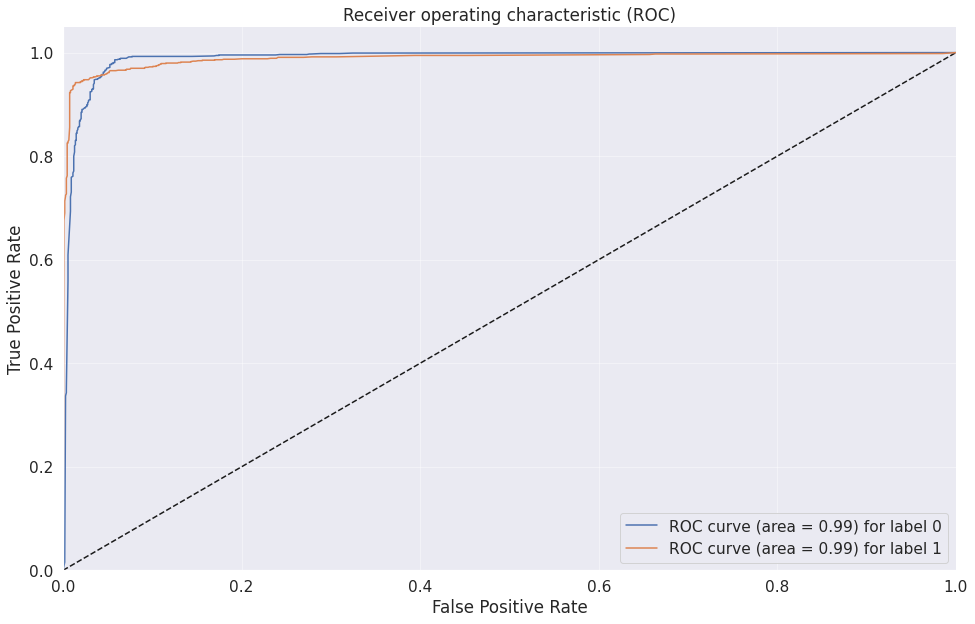

In [46]:
# Visualise the ROC curve model performance for final DLXGB model
def plot_multiclass_roc_dcnn_xgboost(clf, X_test, y_test, n_classes, figsize=(17, 6)):
    y_score = clf.predict_proba(X_test)
    # Structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # Calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic (ROC)')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()
    
plot_multiclass_roc_dcnn_xgboost(clfXGB, X_val_XG, y_val, n_classes=2, figsize=(16, 10))